# Построение ETL пайплайна

## Цель проекта

Написать DAG для Airflow, который ежедневно будет агрегировать данные за предыдущий день и помещать их в новую таблицу Clickhouse.

## Описание проекта

Приложение, для которого необходимо выполнить задачу представляет собой ленту новостей и мессенджер. Для упрощения получения данных за предыдущий день, этот процесс необходимо автоматизировать при помощи Airflow. 

## Декомпозиция задачи

1. В распоряжении 2 таблицы - feed_actions, в которой собираются данные о пользователях ленты новостей и их активности и message_actions в которой собираются данные о пользователях мессенджера и их активности. Для feed_actions необходимо посчитать для каждого пользователя число лайков и просмотров. Для message_action - количество отправленных и полученных сообщений на каждого пользователя.
2. Объединить полученные таблицы.
3. Для этой таблицы посчитать все эти метрики в разрезе по полу, возрасту и ос. 
4. Финальные данные со всеми метриками записать в отдельную таблицу в ClickHouse.

## Код проекта

In [ ]:
# Импорт библиотек
from datetime import datetime, timedelta
import pandas as pd
from io import StringIO
import pandahouse as ph

from airflow.decorators import dag, task
from airflow.operators.python import get_current_context

# Список необходимых столбцов
columns_names = ['event_date', 'dimension', 'dimension_value', 'views', 'likes',
                'messages_received', 'messages_sent', 'users_received', 'users_sent']

#коннект к БД
connection = {
    'host': '',
    'password': '',
    'user': '',
    'database': ''
}

#коннект к БД на запись 
connection_out = {
    'host': '',
    'database':'',
    'user':'', 
    'password':''
}

#запрос в ленту
feed_query = """SELECT user_id,
                       time::DATE as event_date,
                       countIf(action = 'like') as likes,
                       countIf(action = 'view') as views,
                       os,
                       age,
                       gender
                FROM simulator_20230520.feed_actions
                WHERE time::DATE = yesterday()
                GROUP BY user_id, os, age, gender, time::DATE"""

#запрос в мессенджер
messanger_query = """SELECT DISTINCT user_id,
                                     event_date,
                                     messages_sent,
                                     users_sent,
                                     gender,
                                     age,
                                     os,
                                     messages_received,
                                     users_received

                        FROM
                            (SELECT user_id, 
                                   time::DATE event_date,
                                   age,
                                   os,
                                   gender,
                                   COUNT(reciever_id) messages_sent,
                                   COUNT(DISTINCT reciever_id) users_sent
                            FROM simulator_20230520.message_actions
                            WHERE time::DATE = yesterday()
                            GROUP BY user_id, time::DATE, age, os, gender) t1

                            FULL OUTER JOIN

                            (SELECT reciever_id,
                                   time::DATE event_date,
                                   age,
                                   os,
                                   gender,
                                   COUNT(user_id) messages_received,
                                   COUNT(DISTINCT user_id) users_received
                            FROM simulator_20230520.message_actions
                            WHERE time::DATE = yesterday()
                            GROUP BY reciever_id, time::DATE, age, os, gender) t2

                            ON t1.user_id = t2.reciever_id"""

#создание таблицы в БД


# Дефолтные параметры, которые прокидываются в таски
default_args = {
    'owner': 'i.vashkovets',
    'depends_on_past': False,
    'retries': 2,
    'retry_delay': timedelta(minutes=5),
    'start_date': datetime(2023, 6, 11),
}

# Интервал запуска DAG
schedule_interval = '0 5 * * *'

#dag
@dag(default_args=default_args, schedule_interval=schedule_interval, catchup=False, tags=['i-vashkovets-19'])
def etl_dag_to_new_table_v():
    #Данные из базы feed_actions
    @task
    def extract_feed(feed_query, connection):
        feed = ph.read_clickhouse(feed_query, connection=connection)
        return feed
    #Данные из базы message_actions
    @task
    def extract_message(messanger_query, connection):
        messanger = ph.read_clickhouse(messanger_query, connection=connection)
        return messanger
    #Объединение таблиц
    @task
    def transform_merge(feed_table, messanger_table):
        final_table = feed_table.merge(messanger_table, how='inner')
        return final_table
    #срезы
    #пол
    @task
    def gender_slice(df_final): 
        df_final_gender = df_final.groupby(['gender', 'event_date'])['likes', 'views', 'messages_sent', 'users_sent', 'messages_received', 'users_received'].sum().reset_index()
        df_final_gender.rename(columns={'gender': 'dimension_value'}, inplace=True)
        df_final_gender['dimension'] = 'gender'
        return df_final_gender[columns_names]
    #ос
    @task
    def os_slice(df_final):
        df_final_os = df_final.groupby(['os', 'event_date'])['likes', 'views', 'messages_sent', 'users_sent', 'messages_received', 'users_received'].sum().reset_index()
        df_final_os.rename(columns={'os': 'dimension_value'}, inplace=True)
        df_final_os['dimension'] = 'os'
        return df_final_os[columns_names]
    #возраст
    @task
    def age_slice(df_final):
        df_final_age = df_final.groupby(['age', 'event_date'])['likes', 'views', 'messages_sent', 'users_sent', 'messages_received', 'users_received'].sum().reset_index()
        df_final_age.rename(columns={'age': 'dimension_value'}, inplace=True)
        df_final_age['dimension'] = 'age'
        return df_final_age[columns_names]
    # Функция объединения срезов
    @task
    def sliced_final_table(gender_final, os_final, age_final):
        return pd.concat([gender_final, os_final, age_final]).reset_index(drop=True)
     # Функция записи данных в новую таблицу в ClickHouse
    @task
    def load(sliced_final):
        query_out = """CREATE TABLE IF NOT EXISTS test.i_vashkovets_19
                    (event_date Date,
                    dimension String,
                    dimension_value String,
                    views UInt64,
                    likes UInt64,
                    messages_sent UInt64,
                    users_sent UInt64,
                    messages_received UInt64,
                    users_received UInt64
                    )
                    ENGINE = MergeTree()
                    ORDER BY event_date"""
        ph.execute(query=query_out, connection=connection_out)
        ph.to_clickhouse(sliced_final, 'i_vashkovets_19', index = False, connection=connection_out)
        
    #связи
    feed_table = extract_feed(feed_query, connection)
    messanger_table = extract_message(messanger_query, connection)
    df_final = transform_merge (feed_table, messanger_table)
    gender_final = gender_slice(df_final)
    os_final = os_slice(df_final)
    age_final = age_slice(df_final)
    sliced_final = sliced_final_table(gender_final, os_final, age_final)
    upload = load(sliced_final)
    
etl_dag_to_new_table_v = etl_dag_to_new_table_v()

## Результат выполнения скрипта

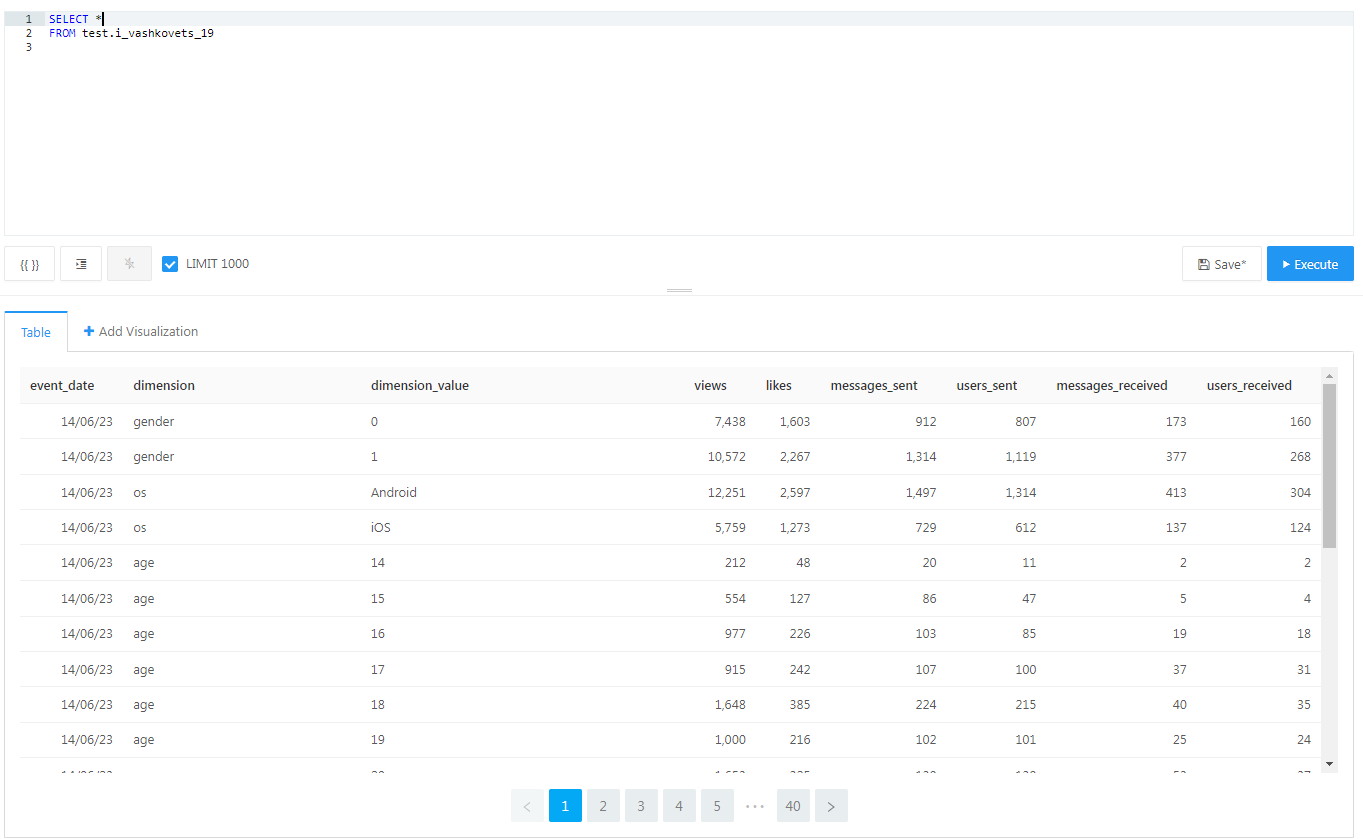

## Общий вывод

В результате выполнения задачи был автоматизирован процесс получения данных за предыдущий день из базы данных Clickhouse, преобразован средствами Python и записан в новую таблицу в Clickhouse. Для автоматического запуска скрипта использован планировщик Airflow.